In [4]:
#installing libraries
!pip install wordcloud
!pip install emot
!pip install TextBlob
!pip install contractions
!pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
#importing libraries
import numpy as np
import pandas as pd 
import chart_studio
import re
import string
import emot
import collections
import ipywidgets
import contractions
import cufflinks
import nltk.tokenize

import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm


from textblob import TextBlob
from google.colab import widgets
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [6]:
#Importing dataset
df = pd.read_csv('/content/FinalOutput.csv')
df.head()

MsgID              Timestamp                 Author   ThreadID  \
0  'jezyem1'  '2023-04-04 18:47:55'               'hand13'  '12c29lm'   
1  'jezyiiu'  '2023-04-04 18:48:44'  'Electronic_End_2192'  '12c3dxv'   
2  'jezyobl'  '2023-04-04 18:49:57'         'natsu_-_erza'  '12c3ulw'   
3  'jezyoou'  '2023-04-04 18:50:02'         'hungry_viper'  '126rd66'   
4  'jezyq2z'  '2023-04-04 18:50:19'  'Electronic_End_2192'  '12bqner'   

                                         ThreadTitle  \
0  'Afraid AI will learn your face from online ph...   
1  'A reminder that Amazon Sidewalk now covers 90...   
2  'Never logged in still website shows hello xyz...   
3  'Your Amazon Firestick does not shut off. It s...   
4                     'Best FF alternative for ios?'   

                                             MsgBody    ReplyTo  \
0  'how can this be understood? azure recognized ...  'jezxs4s'   
1       'Sounds like a problem for Amazon users lol'        '-'   
2  'Yes I did. Yet same problem. So I used my pho...  'jezy3c9'   
3  'What kind of analyzer software do you use on ...  'jeb4a1g'   
4  'Brave DuckDuckGo and SnowHaze are the best br...        '-'   

                                           Permalink Unnamed: 8 Unnamed: 9  \
0  '/r/privacy/comments/12c29lm/afraid_ai_will_le...        NaN        NaN   
1  '/r/privacy/comments/12c3dxv/a_reminder_that_a...        NaN        NaN   
2  '/r/privacy/comments/12c3ulw/never_logged_in_s...        NaN        NaN   
3  '/r/privacy/comments/126rd66/your_amazon_fires...        NaN        NaN   
4  '/r/privacy/comments/12bqner/best_ff_alternati...        NaN        NaN   

  Unnamed: 10 Unnamed: 11  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN         NaN  
4         NaN         NaN

In [7]:
#EDA
df['MsgBody']

0        'how can this be understood? azure recognized ...
1             'Sounds like a problem for Amazon users lol'
2        'Yes I did. Yet same problem. So I used my pho...
3        'What kind of analyzer software do you use on ...
4        'Brave DuckDuckGo and SnowHaze are the best br...
                               ...                        
12713                                  'Bing chat be like'
12714    'I am fully aware of the implications you snob...
12715    'Im happily just using it to help me world bui...
12716                                             'WokeAI'
12717    'Massive FOMO -  no browsing option for Ralph....
Name: MsgBody, Length: 12718, dtype: object

In [8]:
df.dtypes

MsgID          object
 Timestamp     object
Author         object
ThreadID       object
ThreadTitle    object
MsgBody        object
ReplyTo        object
Permalink      object
Unnamed: 8     object
Unnamed: 9     object
Unnamed: 10    object
Unnamed: 11    object
dtype: object

In [9]:
#Preprocessing the data
def pre_process(text):
    # Remove links
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)

    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

In [10]:
df['processed_text'] = df['MsgBody'].apply(str).apply(pre_process)

In [11]:
df['processed_text']

0        'how can this be understood? azure recognized ...
1             'sounds like a problem for amazon users lol'
2        'yes i did. yet same problem. so i used my pho...
3        'what kind of analyzer software do you use on ...
4        'brave duckduckgo and snowhaze are the best br...
                               ...                        
12713                                  'bing chat be like'
12714    'i am fully aware of the implications you snob...
12715    'im happily just using it to help me world bui...
12716                                             'wokeai'
12717    'massive fomo - no browsing option for ralph. ...
Name: processed_text, Length: 12718, dtype: object

<Axes: title={'center': 'Top 20 bigrams in reddit before removing spams'}, xlabel='RedditText', ylabel='Count'>

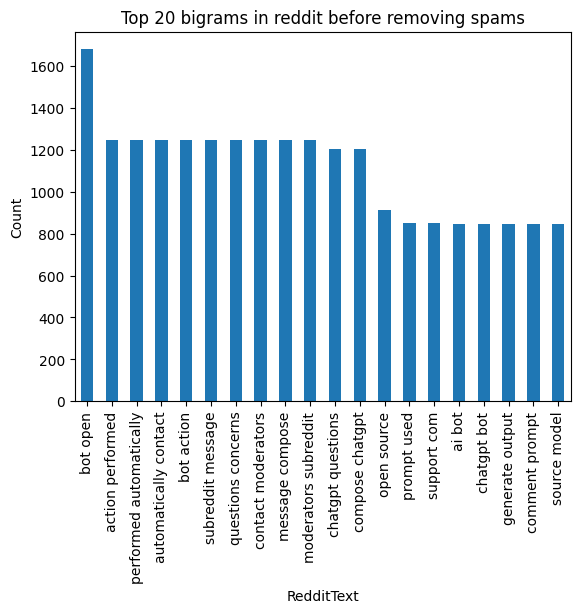

In [12]:
def get_top_n_bigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_bigram(df['processed_text'], 20)

df1 = pd.DataFrame(common_words, columns = ['RedditText' , 'count'])
df1 = df1.groupby('RedditText').sum()['count'].sort_values(ascending=False)

df1.plot(
    kind='bar',
    ylabel='Count',
    title='Top 20 bigrams in reddit before removing spams')

bot action performed 1249
action performed automatically 1249
performed automatically contact 1249
automatically contact moderators 1249
contact moderators subreddit 1249
moderators subreddit message 1249
subreddit message compose 1249
message compose chatgpt 1204
compose chatgpt questions 1204
chatgpt questions concerns 1204
open source model 846
respond comment prompt 843
comment prompt used 843
prompt used generate 843
used generate output 843
generate output post 843
ignore comment post 840
comment post doesnt 840
post doesnt prompt 840
public discord server 840


<Axes: title={'center': 'The 20 most frequent tri-grams in the dataset (without stopwords and spams)'}, xlabel='TweetText', ylabel='Count'>

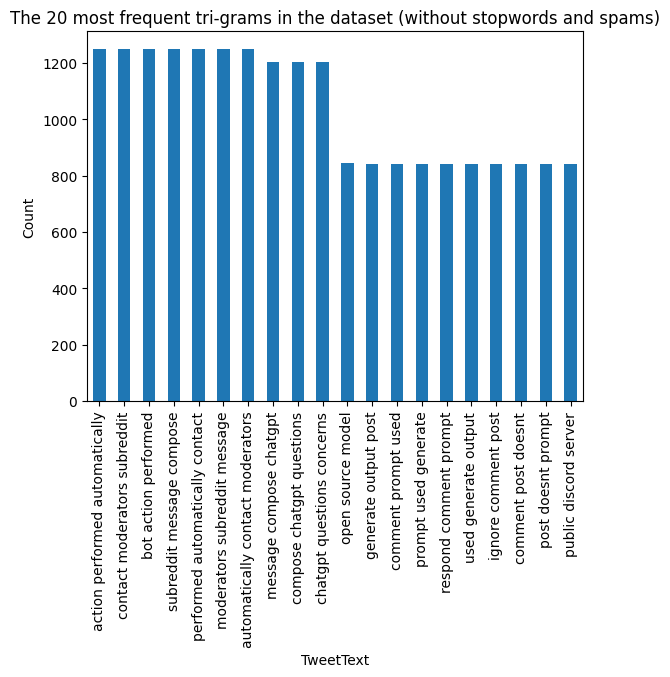

In [13]:

def get_top_n_trigram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_trigram(df['processed_text'], 20)

for word, freq in common_words:
    print(word, freq)

df6 = pd.DataFrame(common_words, columns = ['TweetText' , 'count'])
df6.groupby('TweetText').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',
    ylabel='Count',
    
    title='The 20 most frequent tri-grams in the dataset (without stopwords and spams)')

In [14]:
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

sid = SentimentIntensityAnalyzer()
emot_obj = emot.core.emot()

cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

pio.renderers.default = 'colab'

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [15]:
wordnet_lem = WordNetLemmatizer()

# Lemmatize processed text and join everything in a list
df['text_lem'] = df['processed_text'].apply(wordnet_lem.lemmatize)
all_words_lem = ' '.join([word for word in df['text_lem']])

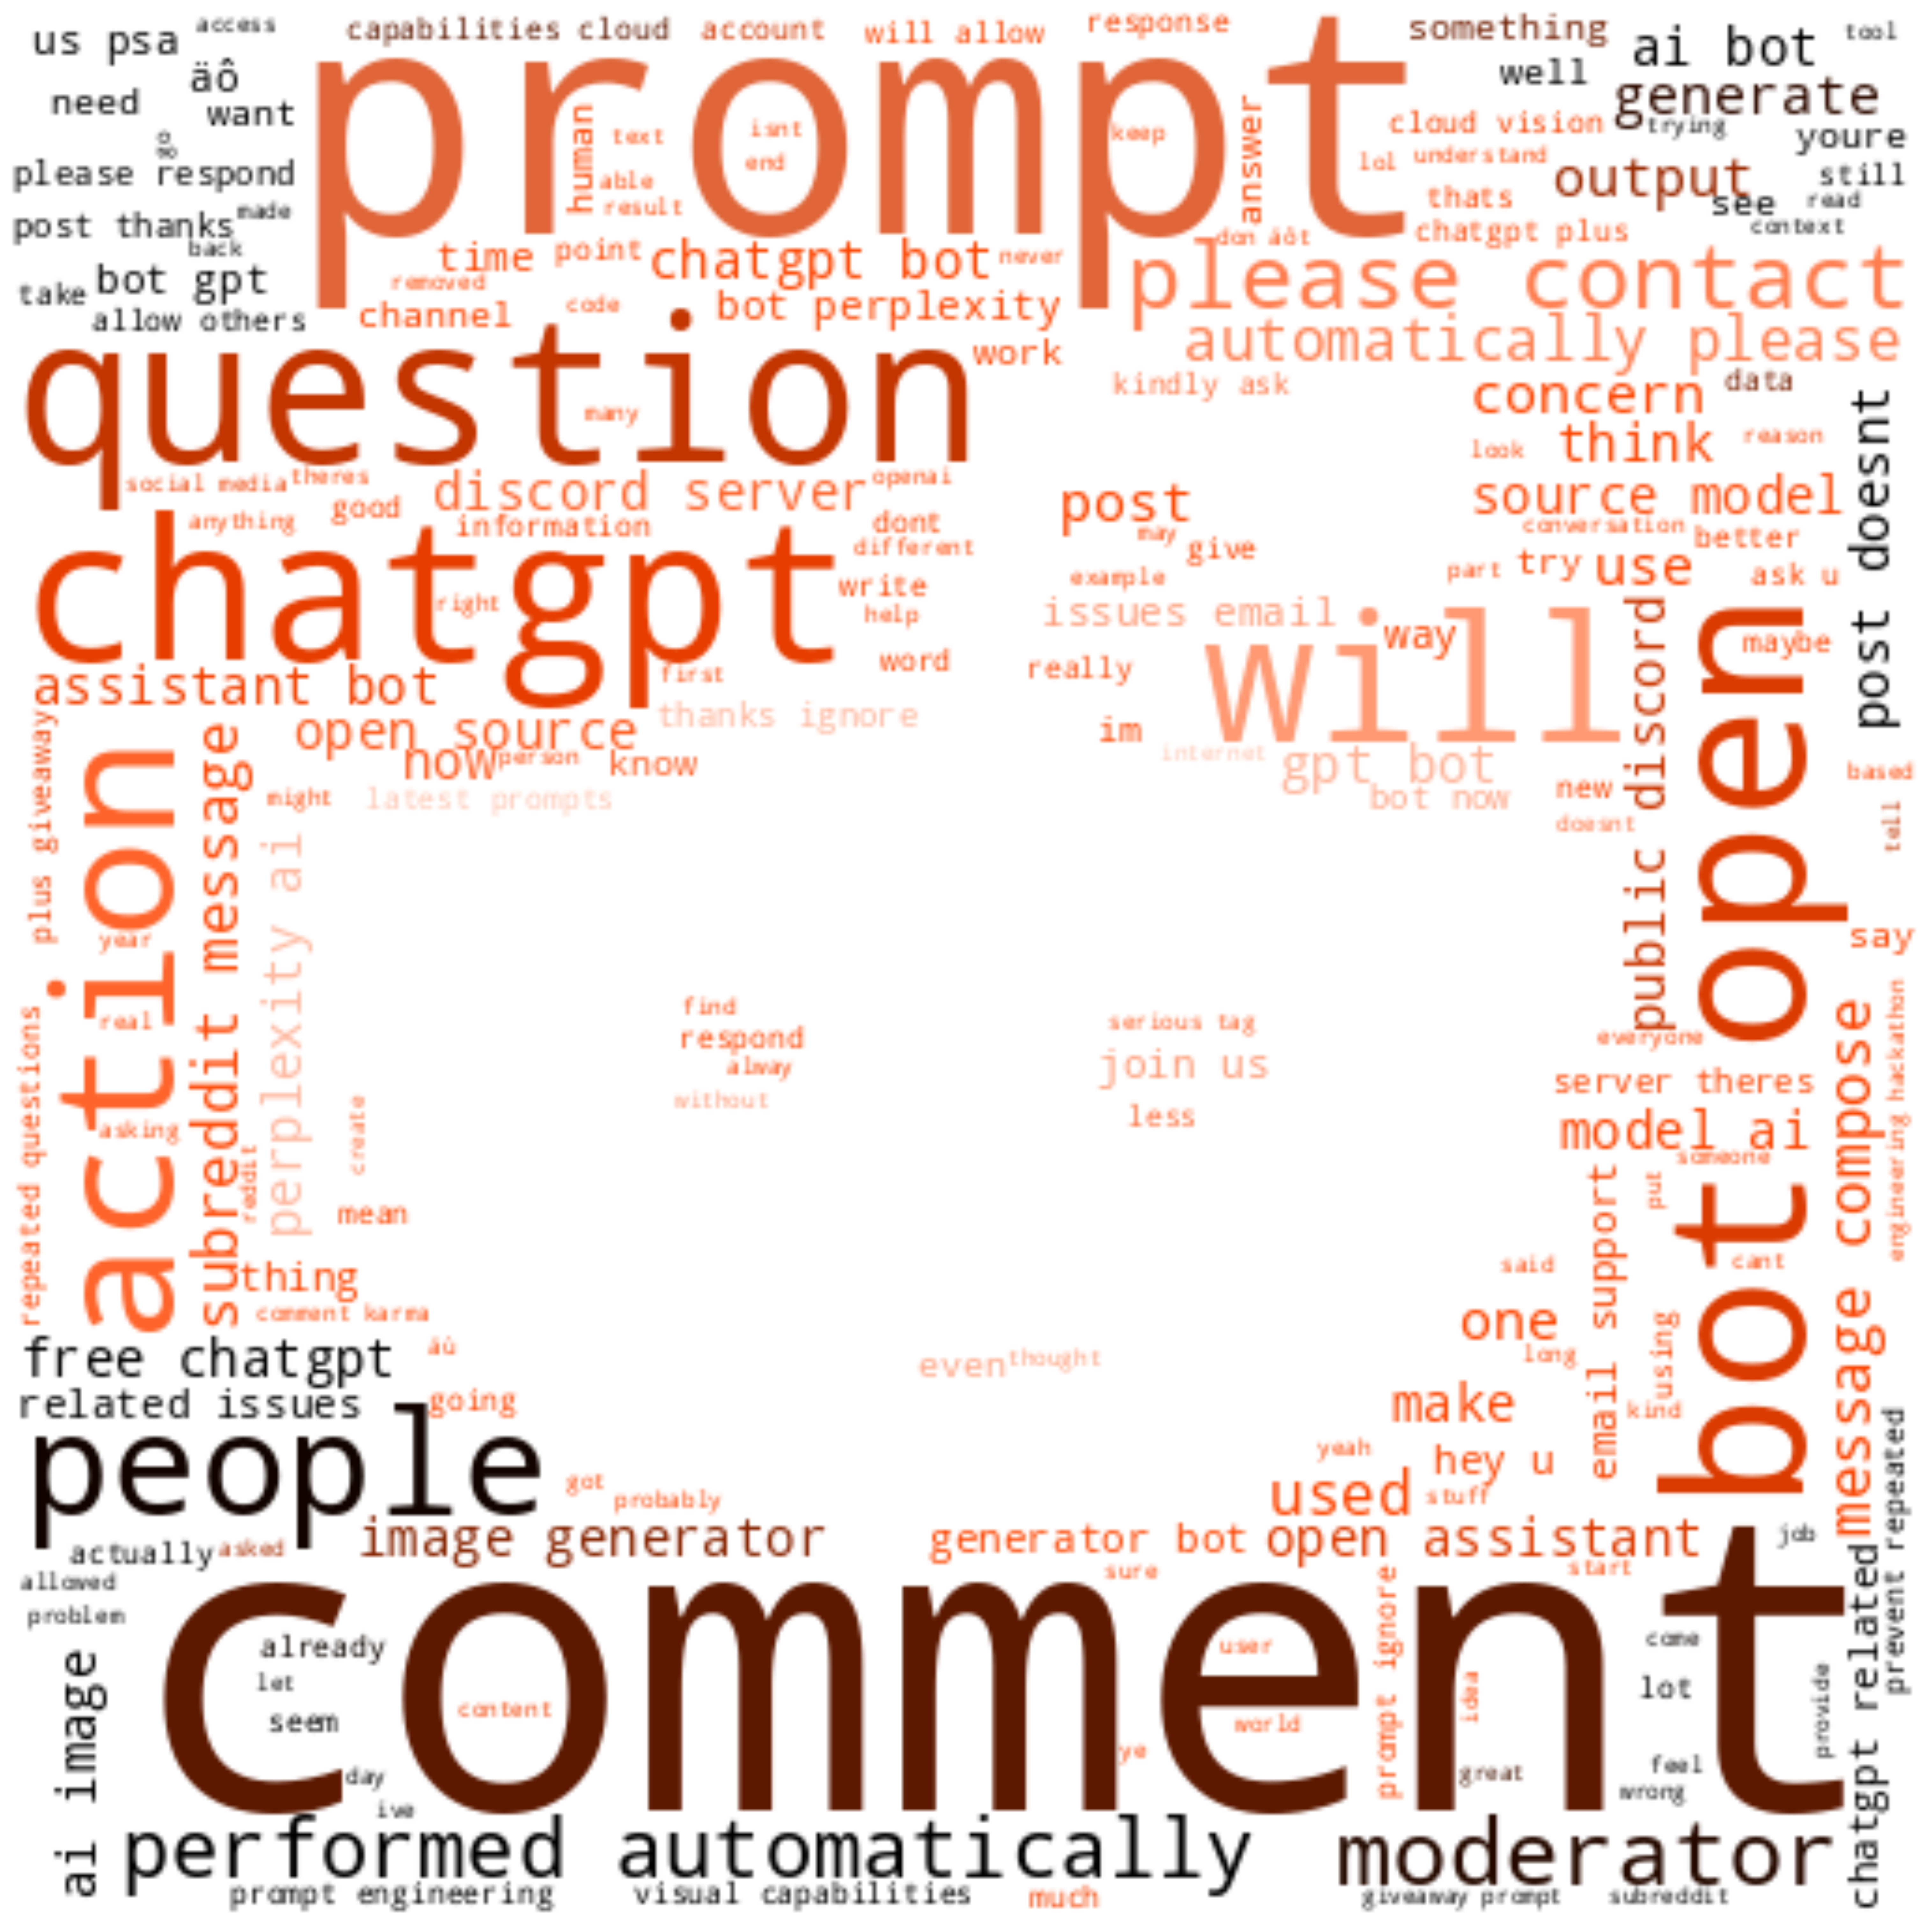

In [16]:


mask = np.array(Image.open("/content/reddit-logo.png").convert("RGB")) # convert grayscale image to RGB
stopwords = set(STOPWORDS)

wordcloud_twitter = WordCloud(height=2000,
                              width=2000,
                              background_color="white",
                              mode="RGBA",
                              stopwords=stopwords,
                              max_font_size=300,
                              mask=mask).generate(all_words_lem)

# Create coloring from the image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[20,20], dpi=300)
plt.axis('off')
plt.tight_layout(pad=0)
plt.imshow(wordcloud_twitter.recolor(color_func=image_colors), interpolation="bilinear")

# Store visualization to file
plt.savefig("reddit_logo.png", format="png")

plt.show()


In [17]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

df['vader_polarity'] = df['processed_text'].map(
    lambda text: sid.polarity_scores(text)['compound'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


<Axes: title={'center': 'distributions of sentimental polarities'}, ylabel='Frequency'>

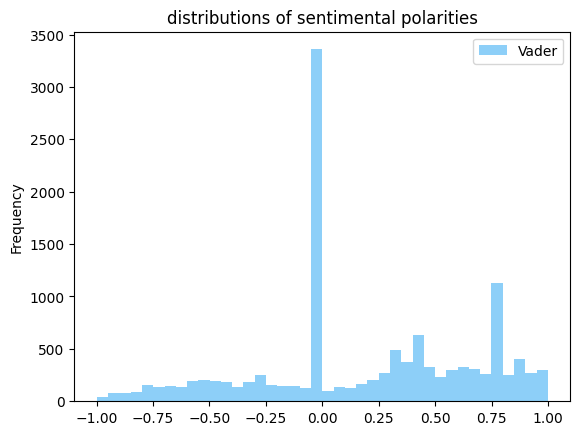

In [18]:
polarity_df = df[['vader_polarity']]
polarity_df = polarity_df.rename(columns={'vader_polarity': 'Vader'})

polarity_df.plot(
    kind='hist',
    bins=40,
    xlabel='Polarity',
    ylabel='Count',
    title='distributions of sentimental polarities',
    color=['#1DA1F2'],
    alpha=0.5, # adjust the opacity of the bars
    stacked=False # set stacked to False for grouped histograms
)

In [19]:
polarity_df.describe()

Vader
count  12718.000000
mean       0.193099
std        0.475541
min       -0.998200
25%        0.000000
50%        0.077200
75%        0.613250
max        0.999700

In [20]:
stop_words = nltk.corpus.stopwords.words('english')
def remove_stop_words(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

df['stop_text'] = df['processed_text'].apply(lambda x: remove_stop_words(x))

In [21]:
# We define a list of topics
topics = ['action performed',
          'chatgpt questions',
          'open source',
          'prompt used', 
          'generate output',
          ]

vader_sentiments = df['vader_polarity'].tolist()

text = df['stop_text'].tolist()

# We create a new column Topic
df['Topic'] = ""
for topic in topics:
    df.loc[df['stop_text'].str.contains(topic), 'Topic'] = topic

# We create a new DataFrame with columns topic / sentiment / source
data = []
for topic in topics:
    topic_rows = df[df['Topic'] == topic]
    # Average sentiment per topic
    vader_sentiments = topic_rows['vader_polarity'].sum() / topic_rows.shape[0]
    
    
    # Append data
    data.append({'Topic': topic, 'Sentiment': vader_sentiments, 'Source': 'Vader'})
   
    

df_new = pd.DataFrame(data)

# Plot the sentiment for each topic
fig = px.bar(df_new,
             x='Topic',
             y='Sentiment',
             color='Source',
             barmode='group',
             color_discrete_sequence = ['#1DA1F2', '#EB8C17'],
             title='Comparative sentimental analysis by topic',
             template='plotly_white')

fig.update_traces(marker_line_width=1,
                  marker_line_color="black")

fig.show()